#  Продуктовые метрики

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Чтобы держать руку на пульсе бизнеса, нужно строить довольно много продуктовых метрик. Более того, нужно понимать насколько адекватно эти метрики построены и насколько сильно они могут колебаться. Рассмотрим два таких показателя: возвращаемость (retention) и среднюю выручку (revenue per user, RPU)

In [2]:
visits = pd.read_csv('marketing_log.csv', sep='\t', parse_dates=['date'])
print(f'Размерность данных - {visits.shape}')

# отсортируем данные по дате 
visits.sort_values('date', inplace=True)

# сбросим индексирование таблики
visits.reset_index(drop=True, inplace=True)

visits.head()

Размерность данных - (177973, 5)


,date,fullVisitorId,browser,deviceCategory,transactionRevenue
0,2016-08-05,377595677869445136,Chrome,desktop,NaN
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN


In [3]:
visits.dtypes

date                  datetime64[ns]
fullVisitorId                 object
browser                       object
deviceCategory                object
transactionRevenue           float64
dtype: object

In [4]:
visits.isnull().sum()

date                       0
fullVisitorId              0
browser                    1
deviceCategory             1
transactionRevenue    175643
dtype: int64

# 1. Число пользователей

Сколько людей пользуются в день, неделю, месяц?

In [5]:
vists_by_days = visits \
        .groupby('date', as_index=False) \
        .agg(visits_number=('fullVisitorId', 'nunique'))

vists_by_days.head()

,date,visits_number
0,2016-08-05,2492
1,2016-08-11,2446
2,2016-08-16,2619
3,2016-08-20,1555
4,2016-08-22,2352


Среднее число посетителей в день: 2355.83


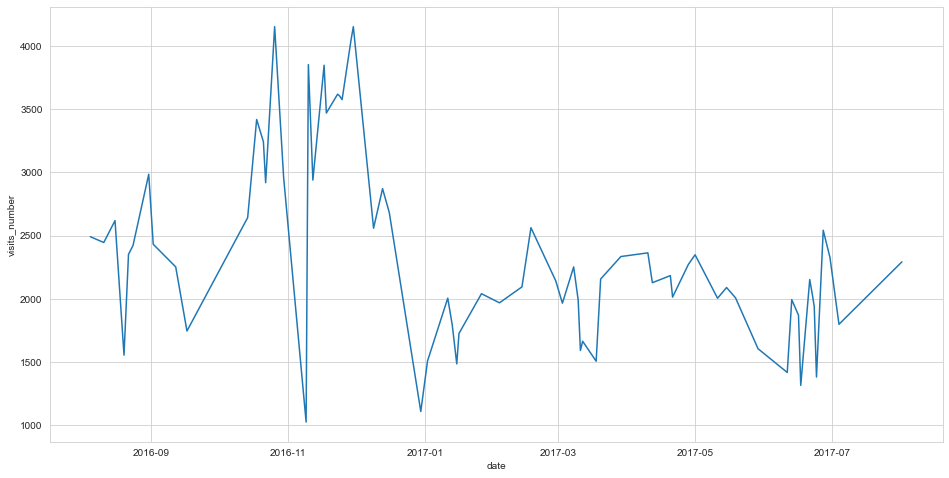

In [6]:
print(f"Среднее число посетителей в день: {round(vists_by_days.visits_number.mean(), 2)}")

plt.figure(figsize=(16, 8))
sns.lineplot(x='date', y='visits_number', data=vists_by_days);

# 2. Возвращаемость (retention)

Первый показатель, который обычно интересует бизнес это возвращаемость (retention): 

* `retention_1`  - вернулся ли игрок после **первого** дня с момента посещения магазина?
* `retention_7`  - вернулся ли игрок после **седьмого** дня с момента посещения магазина?

Заведём новую колонку: дата первого появления юзера.

In [7]:
visits['first_visit'] = visits.groupby('fullVisitorId')['date'].transform('min')
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,first_visit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05


Ради интереса посмотрим на то, как распределено число дней между текущим и первым посещениями.

In [8]:
visits['days_from_first_visit'] = (visits.date - visits.first_visit).apply(lambda x: x.days)
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,first_visit,days_from_first_visit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05,0
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05,0
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05,0
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05,0
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05,0


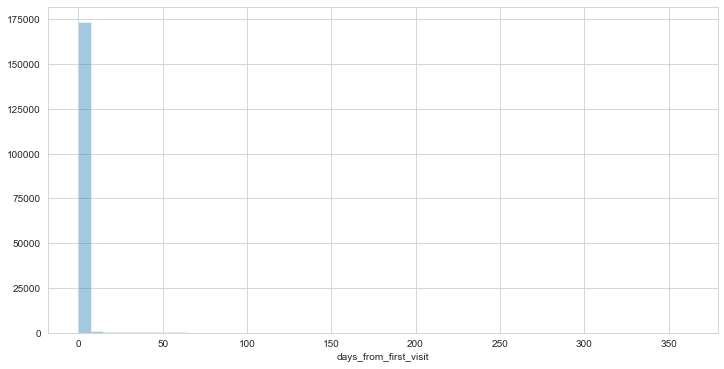

In [9]:
plt.figure(figsize=(12, 6));
sns.distplot(visits.days_from_first_visit, kde=False);

Видно, что чаще всего первое посещение оказывается последним.

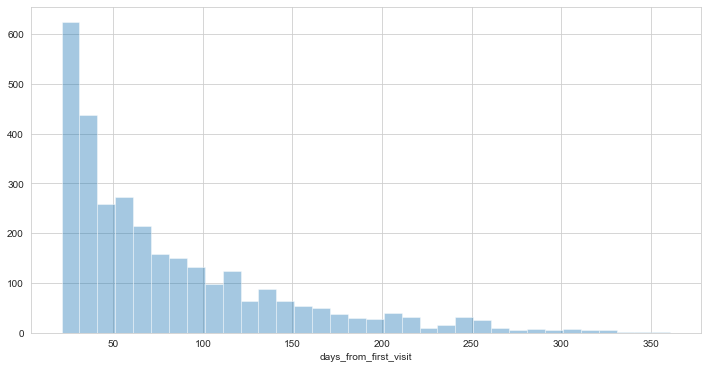

In [10]:
data = visits.query('days_from_first_visit > 20').days_from_first_visit
plt.figure(figsize=(12, 6));
sns.distplot(data, kde=False);

Найдём для каждого человека разность в днях между первым и последним посещениями: 

In [11]:
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,first_visit,days_from_first_visit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05,0
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05,0
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05,0
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05,0
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05,0


In [12]:
first_visits = visits \
                .groupby(['first_visit', 'fullVisitorId'], as_index=False) \
                .agg({'days_from_first_visit': 'max'})

first_visits.head()

,first_visit,fullVisitorId,days_from_first_visit
0,2016-08-05,1000971553963693366,0
1,2016-08-05,1006834109386002658,0
2,2016-08-05,101246539776970727,0
3,2016-08-05,1013171119747358712,0
4,2016-08-05,1015220001673280213,0


In [13]:
first_visits.shape

(159518, 3)

Посчитаем `retention_7`.  Если `days_from_first_visit` оказывается больше 7, значит человек вернулся более, чем через 7 дней после первого посещения. Такие люди нас и интересуют. Найдём их количество.

In [14]:
retention = first_visits \
                .groupby('first_visit') \
                .agg(success=('days_from_first_visit', lambda w: sum(w >= 7)),
                     total=('days_from_first_visit', 'count'))

retention.head()

,success,total
first_visit,,
2016-08-05,108,2492
2016-08-11,103,2413
2016-08-16,102,2543
2016-08-20,35,1532
2016-08-22,92,2234


Построим график. 

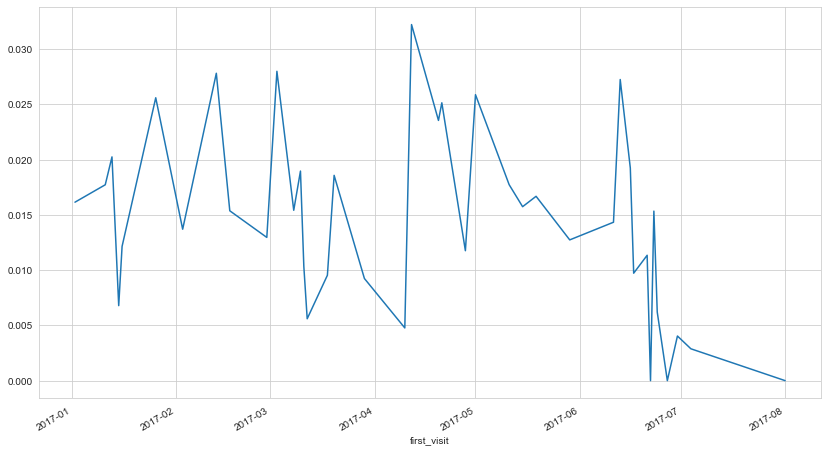

In [15]:
retention['retention'] = retention['success'] / retention['total']
retention['retention'][30:120].plot(figsize=(14, 8));

Есть много точечных оценок доли людей, которая возвращается для каждой даты. Но этого мало, каждая точка строится по разному числу наблюдений и нам хотелось бы понимать насколько оценка точная. Возвращаемость - это доля. Значит можно построить для неё доверителльный интервал с помощью ЦПТ:

$$
\hat p \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}} 
$$

In [16]:
retention.head()

,success,total,retention
first_visit,,,
2016-08-05,108,2492,0.043339
2016-08-11,103,2413,0.042685
2016-08-16,102,2543,0.040110
2016-08-20,35,1532,0.022846
2016-08-22,92,2234,0.041182


In [17]:
alpha = 0.05

# стандартная ошибка
retention['se'] = np.sqrt(retention['retention'] * (1 - retention['retention']) / retention['total'])

# границы интервалов
q = stats.norm.ppf(1 - alpha/2)
retention['left'] = retention['retention'] - q * retention['se']
retention['right'] = retention['retention'] + q * retention['se']

retention.head()

,success,total,retention,se,left,right
first_visit,,,,,,
2016-08-05,108,2492,0.043339,0.004079,0.035344,0.051333
2016-08-11,103,2413,0.042685,0.004115,0.034620,0.050751
2016-08-16,102,2543,0.040110,0.003891,0.032484,0.047736
2016-08-20,35,1532,0.022846,0.003817,0.015364,0.030328
2016-08-22,92,2234,0.041182,0.004204,0.032942,0.049422


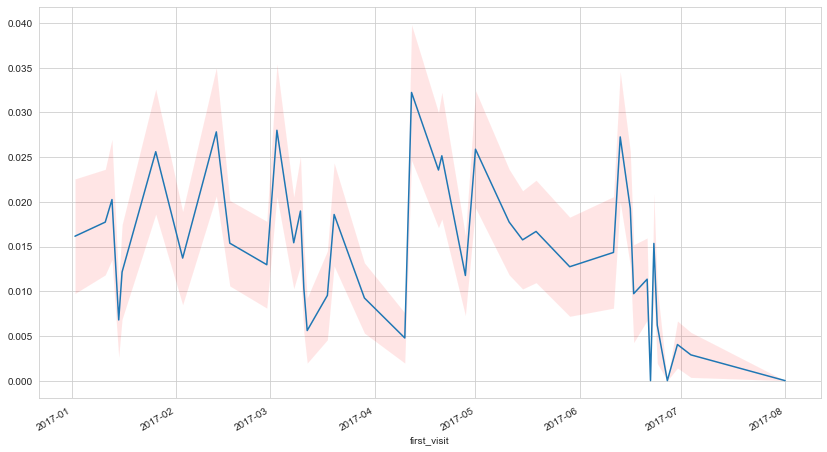

In [18]:
df = retention[30:120]

df['retention'].plot(figsize=(14, 8))
plt.fill_between(df.index, df['left'], df['right'], facecolor='red', alpha=0.1, interpolate=True);

# 3. Средний доход с пользователя (RPU)

Посмотрим как часто люди покупают.

In [19]:
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,first_visit,days_from_first_visit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05,0
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05,0
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05,0
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05,0
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05,0


In [20]:
# Процент покупок 
(100 * (1 - visits['transactionRevenue'].isnull().sum() / visits.shape[0])).round(2)

1.31

Всего лишь в $1\%$ случаев. Это очень редко, но с этой правдой жизни ничего не поделаешь. Оставим только тех, кто правда что-то покупал.

In [21]:
# будем строить RPU на месячной основе
visits['month'] = visits['date'].apply(lambda x: x.strftime('%Y-%m'))

purchases = visits.dropna(subset=['transactionRevenue'])
purchases.shape

(2330, 8)

Посмотрим на распределение стоимостей покупок.

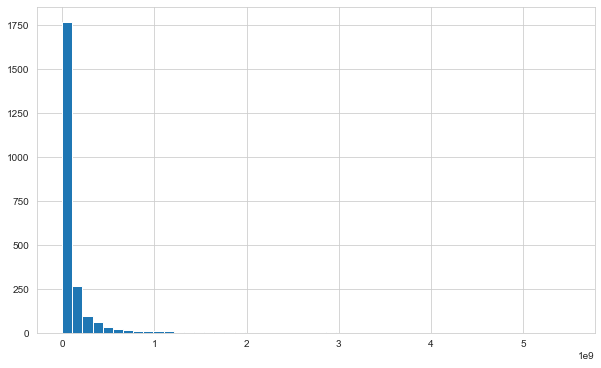

In [22]:
purchases['transactionRevenue'].hist(bins=50, figsize=(10, 6));

Видим, что есть выбросы. Удалим их из выборки. Для того, что применять ЦПТ, мы предполагаем, что ни одна случайная величина из выборки не выделяется на фоне остальных. 

In [23]:
q99 = purchases['transactionRevenue'].quantile(0.99)
q99

1194364900.0000002

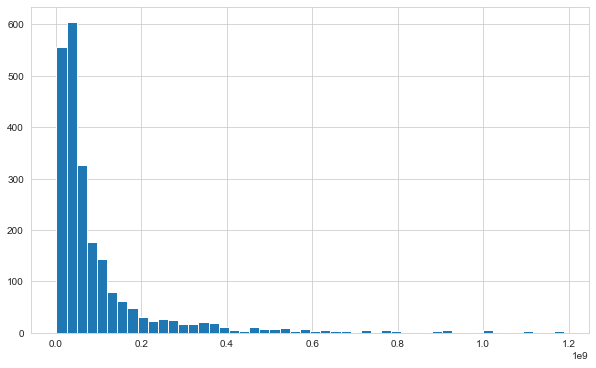

In [24]:
purchases = purchases[purchases['transactionRevenue'] < q99]
purchases['transactionRevenue'].hist(bins=50, figsize=(10, 6));

Посчитаем среднее, стандартное отклонение и число наблюдений для каждого месяца. 

In [25]:
date_purchases = visits \
                    .groupby(['month']) \
                    .agg(rpu=('transactionRevenue', 'mean'),
                         count=('transactionRevenue', 'count'),
                         sd=('transactionRevenue', 'std'))

date_purchases.head()

,rpu,count,sd
month,,,
2016-08,1.403108e+08,302,2.576639e+08
2016-09,1.596071e+08,63,2.466225e+08
2016-10,1.495286e+08,154,2.847047e+08
2016-11,1.582393e+08,298,3.637715e+08
2016-12,1.078180e+08,249,2.386044e+08


Наконец, воспользуемся формулой для строительства доверительного интервала для среднего: 

$$
\hat \mu \pm z_{1 - \frac{\alpha}{2}} \cdot \frac{sd} {\sqrt{n}} 
$$

In [26]:
alpha = 0.05

# границы интервалов
q = stats.norm.ppf(1 - alpha/2)
date_purchases['left'] = date_purchases['rpu'] - q * date_purchases['sd']/np.sqrt(date_purchases['count'])
date_purchases['right'] = date_purchases['rpu'] + q * date_purchases['sd']/np.sqrt(date_purchases['count'])

date_purchases.tail()

,rpu,count,sd,left,right
month,,,,,
2017-04,1.112212e+08,221,2.348075e+08,8.026381e+07,1.421785e+08
2017-05,9.395333e+07,216,1.220328e+08,7.767920e+07,1.102275e+08
2017-06,1.163418e+08,307,3.751088e+08,7.438173e+07,1.583019e+08
2017-07,5.428286e+07,7,1.379814e+07,4.406124e+07,6.450447e+07
2017-08,1.931381e+08,43,4.787008e+08,5.005845e+07,3.362178e+08


Изобразим динамику RPU выручки на графике: 

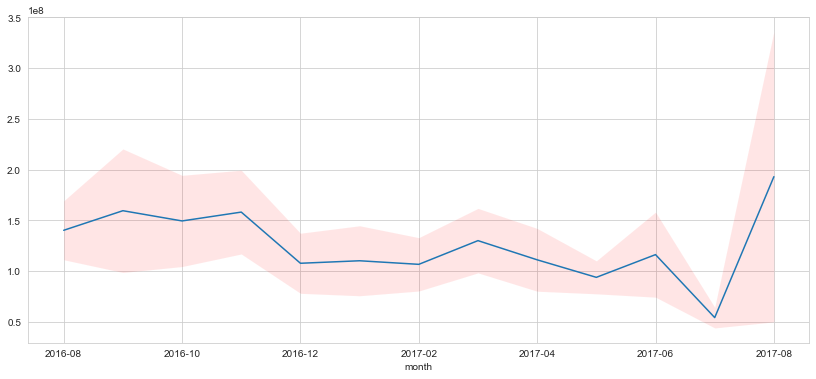

In [27]:
date_purchases['rpu'].plot(figsize=(14, 6))
plt.fill_between(date_purchases.index, date_purchases['left'], date_purchases['right'], 
                 facecolor='red', alpha=0.1, interpolate=True);